In [2]:
from correctingagent.experiments import experiment_tracking
from correctingagent.util import database
from correctingagent.world import world
from collections import defaultdict
from correctingagent.models import prob_model
from correctingagent.experiments import colour_model_evaluation
from correctingagent.agents import PGMAgent, teacher
from correctingagent.experiments import experiment
from correctingagent.world.rules import Rule

In [3]:
bigdb = database.BigExperimentDB()
bigdb.get_df(show_only_done=True)

,experiment_name,status
index,,
33,bigthreerules_new_teacher,done
34,bigthreerules_old_teacher_no_corr,done
36,bigthreerules_new_teacher_no_corr,done
37,bigmaroon_old_teacher,done
38,bigmaroon_old_teacher_no_corr,done
39,bigmaroon_new_teacher,done
41,bigmaroon_new_teacher,done
42,bigmaroon_new_teacher_no_corr,done
45,bigmaroon_old_teacher,done


In [22]:
colour_model_evaluation.evaluate_colour_model(cm)

True Label  p=1 p=0
Predict p=1| 10 | 5 |
        p=0| 0 | 55 |


In [2]:
rfs = list(experiment_tracking.get_rfs(205))
for i, rf in enumerate(rfs):
    ag, goal, colours = rf.load_agent()
    w = world.RandomColoursWorld(problem_directory=f'big_tworules_random_colours_old2/big_tworules_random_colours{i}', problem_number=1)
    print(test_goal(goal, w))

    for colour, values in colours.items():
        cm = prob_model.KDEColourModel(colour, bw=0.05, fix_bw=True, data=values[0], weights=values[1])
        print(f'For colour model of colour {colour}')
        colour_model_evaluation.evaluate_colour_model(cm)
        

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours_old2/big_tworules_random_colours0/problem1.pddl


NameError: name 'test_goal' is not defined

In [3]:
rfs = list(experiment_tracking.get_rfs(135))
run_agent_on_scenario(rfs[0], "big_tworules_random_colours_old2/big_tworules_random_colours21", 22)

KeyboardInterrupt: 

In [2]:
def run_agent_on_scenario(rf, problem_name, problem_number, vis=True, break_on_correction=True, domain_file='blocks-domain.pddl'):
    ag, goal, colours = rf.load_agent()

    t = teacher.TeacherAgent()
    w = world.RandomColoursWorld(domain_file=domain_file, 
                                 problem_directory=problem_name, 
                                 problem_number=problem_number)
    agent = PGMAgent.PGMCorrectingAgent(w, domain_file=domain_file, teacher=t, colour_model_type='kde')

    for colour, values in colours.items():
        cm = prob_model.KDEColourModel(colour, bw=0.05, data=values[0], weights=values[1])
        agent.colour_models[colour] = cm


    agent.goal = goal
    w = world.RandomColoursWorld(domain_file=domain_file, 
                                 problem_directory=problem_name, 
                                 problem_number=problem_number)
    experiment.do_scenario(agent, w, vis=vis, break_on_correction=break_on_correction)

def test_success_of_agent(experiment_no=135, 
                          problem_directory='big_tworules_random_colours_old2/big_tworules_random_colours', 
                          domain_file='blocks-domain.pddl', vis=False, break_on_correction=False):
    rfs = list(experiment_tracking.get_rfs(experiment_no))
    results = {}
    for i, rf in enumerate(rfs):
        ag, goal, colours = rf.load_agent()
        
        t = teacher.TeacherAgent()
        w = world.RandomColoursWorld(domain_file=domain_file, 
                                     problem_directory=problem_directory+str(i), 
                                     problem_number=1)
        agent = PGMAgent.PGMCorrectingAgent(w, domain_file=domain_file, teacher=t, colour_model_type='kde')

        for colour, values in colours.items():
            cm = prob_model.KDEColourModel(colour, bw=0.05, data=values[0], weights=values[1])
            agent.colour_models[colour] = cm

        reward = 0
        for j in range(50):
            agent.goal = goal
            w = world.RandomColoursWorld(domain_file=domain_file, 
                                         problem_directory=problem_directory+str(i), 
                                         problem_number=j+1)
            experiment.do_scenario(agent, w, vis=vis, break_on_correction=break_on_correction)
            reward += w.reward
        #print(agent.goal.asPDDL())
        #experiment.do_scenario(agent, w, vis=True)
        print(f'Agent nr {i}')
        print(reward)
        results[i] = reward
    return results

In [3]:
results = test_success_of_agent(205, )

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours_old2/big_tworules_random_colours0/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours_old2/big_tworules_random_colours0/problem1.pddl
blocks-domain.pddl False
planning 0.6054275035858154 time
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours_old2/big_tworules_random_colours0/problem2.pddl
blocks-domain.pddl False
planning 2.1448521614074707 time
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours_old2/big_tworules_random

/home/mappelgren/Desktop/pgmpy/pgmpy/factors/discrete/DiscreteFactor.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi.values = phi.values[slice_]
/home/mappelgren/Desktop/pgmpy/pgmpy/factors/discrete/DiscreteFactor.py:633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  phi1.values = phi1.values[slice_]


T: No, now you cannot put b1 in the tower because you must put yellow blocks on purple blocks
blocks-domain.pddl False
planning 0.012310981750488281 time
T: No, now you cannot put b5 in the tower because you must put orange blocks on purple blocks
blocks-domain.pddl False
planning 0.014694690704345703 time
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours_old2/big_tworules_random_colours0/problem21.pddl
blocks-domain.pddl False
planning 0.02352595329284668 time
T: No, now you cannot put b3 in the tower because you must put yellow blocks on purple blocks
blocks-domain.pddl False
planning 0.013652563095092773 time
T: No, now you cannot put b3 in the tower because you must put yellow blocks on purple blocks
blocks-domain.pddl False
planning 0.012322187423706055 time
T: No, now you cannot put b3 in the tower because you must put yellow blocks on purple blocks
blo

KeyboardInterrupt: 

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain-updated.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/colour_count_1/colour_count_10/problem1.pddl


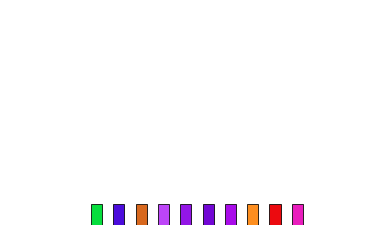

blocks-domain-updated.pddl True
(arm-empty )
(on-table b0)
(clear b0)
(on-table b1)
(clear b1)
(on-table b2)
(clear b2)
(on-table b3)
(clear b3)
(on-table b4)
(clear b4)
(on-table b5)
(clear b5)
(on-table b6)
(clear b6)
(on-table b7)
(clear b7)
(on-table b8)
(clear b8)
(on-table b9)
(clear b9)
(done t0)
(in-tower t0 tower0)
(clear t0)
(done t1)
(in-tower t1 tower1)
(clear t1)
(done tower0)
(done tower1)
(tower tower0)
(tower tower1)
(= (red-count tower0) 0)
(= (blue-count tower0) 0)
(= (green-count tower0) 0)
(= (yellow-count tower0) 0)
(= (purple-count tower0) 0)
(= (orange-count tower0) 0)
(= (pink-count tower0) 0)
(= (red-count tower1) 0)
(= (blue-count tower1) 0)
(= (green-count tower1) 0)
(= (yellow-count tower1) 0)
(= (purple-count tower1) 0)
(= (orange-count tower1) 0)
(= (pink-count tower1) 0)
(purple b1)
(purple b3)
(purple b4)
(purple b5)
(purple b6)
{'b0': {'purple': 2.2240669894050546e-17}, 'b1': {'purple': 0.9590118940976062}, 'b2': {'purple': 3.06761462291538e-13}, 'b3': 

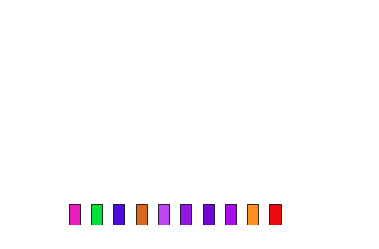

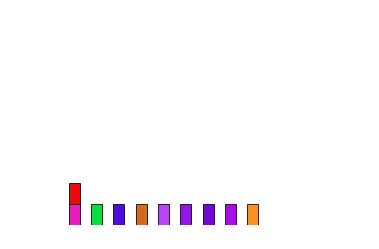

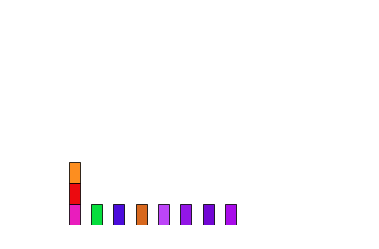

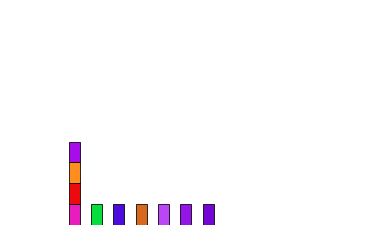

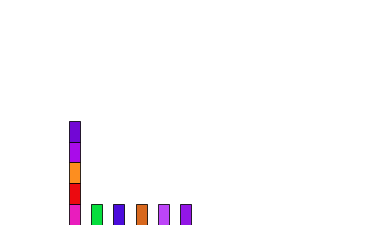

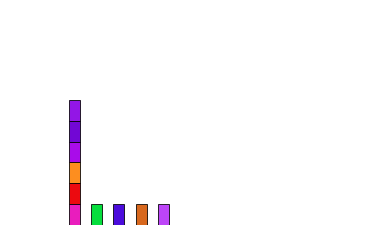

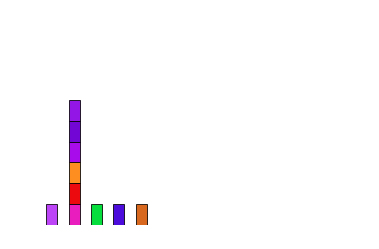

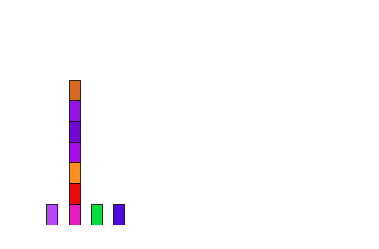

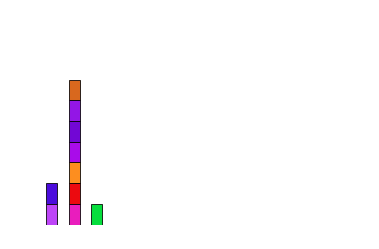

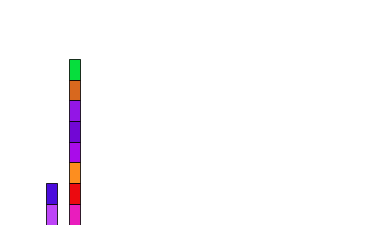

In [3]:
w = world.RandomColoursWorld(domain_file='blocks-domain-updated.pddl', 
                             problem_directory='colour_count_1/colour_count_10', 
                             problem_number=1)
# w.find_plan()
experiment.do_scenario(agent, w, vis=True, break_on_correction=True)

In [15]:
experiments_df = experiment_tracking.get_experiments(107)

In [16]:
experiments_df.iloc[0].config_name

'big_tworules_random_colours/big_tworules_random_colours18'

In [18]:
w = world.RandomColoursWorld(problem_directory=experiments_df.iloc[0].config_name, problem_number=1)

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours/big_tworules_random_colours18/problem1.pddl


In [25]:
for subformula in w.problem.goal.subformulas:
    print(subformula.asPDDL())

(forall (?x) (in-tower ?x))
(forall (?x) (or (not (pink ?x)) (exists (?y) (and (yellow ?y) (on ?x ?y)))))
(forall (?x) (or (not (green ?x)) (exists (?y) (and (pink ?y) (on ?x ?y)))))


In [5]:
def test_goal(goal, w):
    true_goal = w.problem.goal
    true_goal = [subformula.asPDDL() for subformula in true_goal.subformulas]
    i = 0
    for rule in goal.subformulas:

        if rule.asPDDL() in true_goal:
            i += 1
    return i
    

def get_goal_accuracy(big_id):
    results = defaultdict(int)
    rfs = list(experiment_tracking.get_rfs(big_id))
    experiments = experiment_tracking.get_experiments(big_id).config_name
    
    for rf, experiment_name in zip(rfs, experiments):
        agent, goal, colours = rf.load_agent()
        w = world.RandomColoursWorld(problem_directory=experiment_name,
                                    problem_number=1)
        i = test_goal(goal, w)
        results[i] += 1
    return results
    
    

In [30]:
two_rules = {big_id:get_goal_accuracy(big_id) for big_id in [107, 108, 109, 110]}

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours/big_tworules_random_colours18/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours/big_tworules_random_colours41/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours/big_tworules_random_colours48/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_tworules_random_colours/big_tworules_random_colours36/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /hom

In [31]:
three_rules = {big_id:get_goal_accuracy(big_id) for big_id in [76, 103, 104, 105]}

Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_threerules_random_colours/big_threerules_random_colours28/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_threerules_random_colours/big_threerules_random_colours2/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_threerules_random_colours/big_threerules_random_colours26/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsing problem /home/mappelgren/Desktop/correcting-agent/data/big_threerules_random_colours/big_threerules_random_colours49/problem1.pddl
Parsing domain /home/mappelgren/Desktop/correcting-agent/data/domain/blocks-domain.pddl
Parsi

In [32]:
two_rules

{107: defaultdict(int, {3: 50}),
 108: defaultdict(int, {3: 50}),
 109: defaultdict(int, {3: 50}),
 110: defaultdict(int, {3: 50})}

In [33]:
three_rules

{76: defaultdict(int, {4: 50}),
 103: defaultdict(int, {4: 50}),
 104: defaultdict(int, {4: 50}),
 105: defaultdict(int, {4: 50})}